# Mini Projeto 3

## implementação de uma MLP usando Pytorch

Neste projeto, implementei uma Multi-Layer Perceptron (MLP) usando PyTorch para classificar a base de dados MNIST.

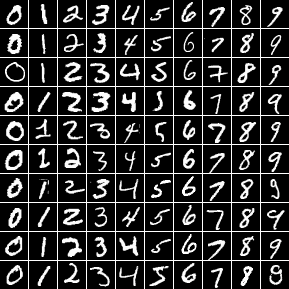

ImpoImportando todas as bibliotecas e a base de dados.

In [14]:
from torchvision import datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [15]:
# Baixar o conjunto de treinamento MNIST, nesse poonto não estou usando nenhuma transformação
batch_size = 128 
base_treinamento = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
base_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [16]:
# Carrega todos os dados
treinamento_img = torch.utils.data.DataLoader(dataset=base_treinamento, batch_size=batch_size, shuffle=True)
teste_img = torch.utils.data.DataLoader(dataset=base_test, batch_size=batch_size, shuffle=False)

Definição do MLP em Pytorch

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Implementação do modelo base de acordo com a solicitação

In [73]:
#Dados da MLP "Direto do classroom"

input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 500  # Número de neurônios na camada oculta
output_size = 10  # Número de saidas possiveis

num_epochs = 5
learning_rate = 0.001

# Definição do modelo
rede = MLP(input_size, hidden_size, output_size)

1. Inicializando o função de otimização (parametros passados no classroom)
2. Iniciando a GPU (para esse caso vou inicia-la apenas se disponivel no PC)

In [74]:
# Inicializando o atimizador

otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate)

PC_Processo = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda ativa GPU
rede.to(PC_Processo) # GPU se disponivel é ativada aqui

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

# calculadora de acuracia

In [75]:
def calcular_acuracia(model, data_loader, PC_Processo):
    model.eval()
    corretos = 0
    total = 0
    with torch.no_grad():
        for imagens, rotulos in data_loader:
            imagens = imagens.view(-1, 28*28).to(PC_Processo)
            rotulos = rotulos.to(PC_Processo)
            saidas = model(imagens)
            _, previstos = torch.max(saidas.data, 1)
            total += rotulos.size(0)
            corretos += (previstos == rotulos).sum().item()
    return (corretos / total) * 100  # Multiplicando por 100 para obter a porcentagem

# chegou a hora de testar o modelo na tentativa de receber dados
## para assim ver os resultados e desse modo aplicar possiveis mudanças

In [76]:
def treinar_e_avaliar(model, treinamento_loader, teste_loader, otimizador, num_epochs, PC_Processo): # função que calcula e treina minha IA (serve para facilitar minha vida em seguida)
    acuracias = []
    criterio = nn.CrossEntropyLoss()
    # Avaliação inicial
    acuracia_inicial = calcular_acuracia(model, teste_loader, PC_Processo)
    acuracias.append(acuracia_inicial)
    print(f"Acurácia inicial: {acuracia_inicial:.4f}")

    # Loop de treinamento
    for epoch in range(num_epochs):
        for i, (imagens, rotulos) in enumerate(treinamento_loader):
            imagens = imagens.view(-1, 28*28).to(PC_Processo)
            rotulos = rotulos.to(PC_Processo)

            # Forward pass
            saidas = model(imagens)
            perda = criterio(saidas, rotulos)

            # Backward pass e otimização
            otimizador.zero_grad()
            perda.backward()
            otimizador.step()

        # Avaliação no conjunto de teste (ou validação) ao final de cada época
        acuracia_epoca = calcular_acuracia(model, teste_loader, PC_Processo)
        acuracias.append(acuracia_epoca)

        # Imprimindo informações
        print(f'Época [{epoch+1}/{num_epochs}], Acurácia de Teste: {acuracia_epoca:.4f}')

    return acuracias

In [77]:
# Exemplo de uso
acuracias_treinamento = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)
valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)

Acurácia inicial: 5.5100
Época [1/5], Acurácia de Teste: 33.8000
Época [2/5], Acurácia de Teste: 65.0400
Época [3/5], Acurácia de Teste: 72.7400
Época [4/5], Acurácia de Teste: 75.4400
Época [5/5], Acurácia de Teste: 76.8900


Plot dos resultados

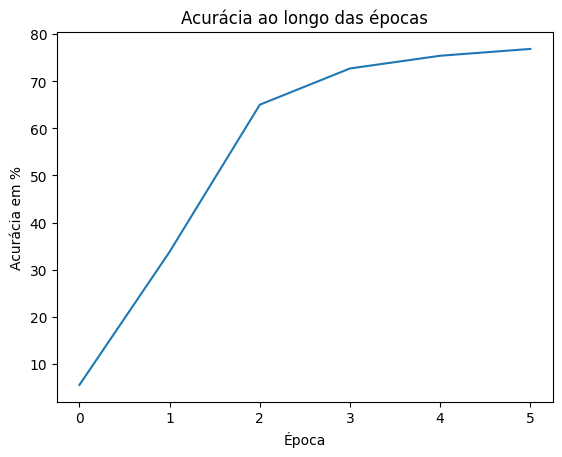

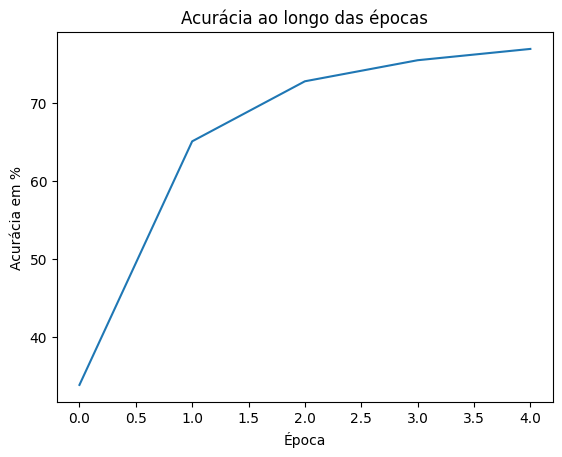

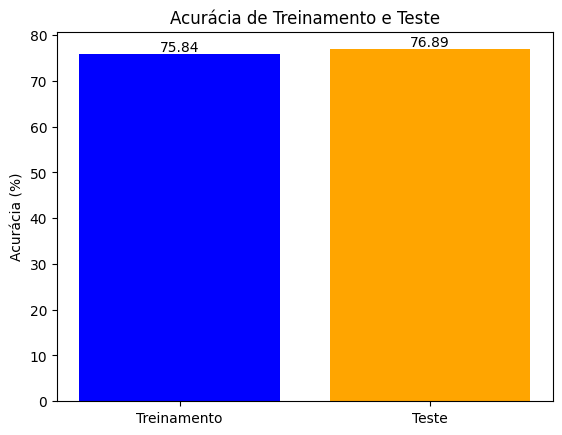

[5.510000000000001, 33.800000000000004, 65.03999999999999, 72.74000000000001, 75.44, 76.89]
[75.845, 76.89]


In [78]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento)
print([valor_treino, valor_teste])


Dado o resultado anterior percebi que que logo após a primeira interação o mesmo esta demorando muito para chegar ao melhor resultado possivel, logo resolvi almenatr o LR na tentativa de acelerar o processo alem de reduzir a complexidade da camada reduzindo o numero de neuronios

In [79]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 258  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 10
batch_size = 128 
learning_rate = 0.005

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 12.8300
Época [1/10], Acurácia de Teste: 75.8700
Época [2/10], Acurácia de Teste: 82.6700
Época [3/10], Acurácia de Teste: 85.3100
Época [4/10], Acurácia de Teste: 87.0500
Época [5/10], Acurácia de Teste: 88.1600
Época [6/10], Acurácia de Teste: 88.8900
Época [7/10], Acurácia de Teste: 89.3200
Época [8/10], Acurácia de Teste: 89.5000
Época [9/10], Acurácia de Teste: 89.8000
Época [10/10], Acurácia de Teste: 89.9800


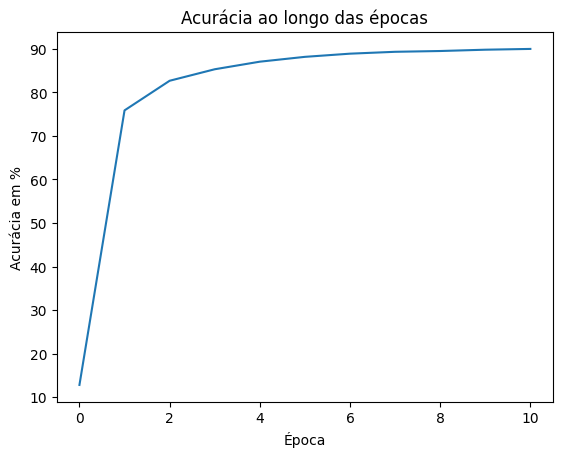

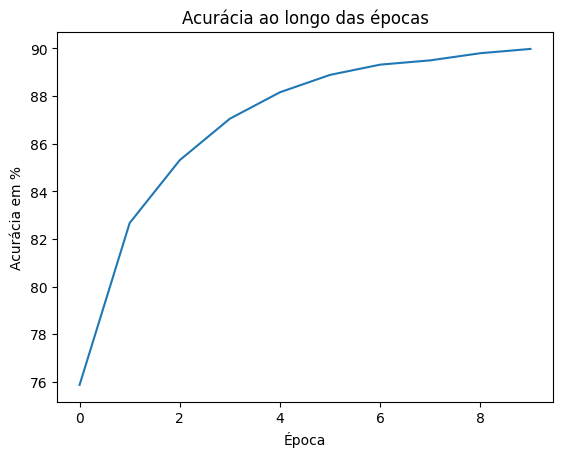

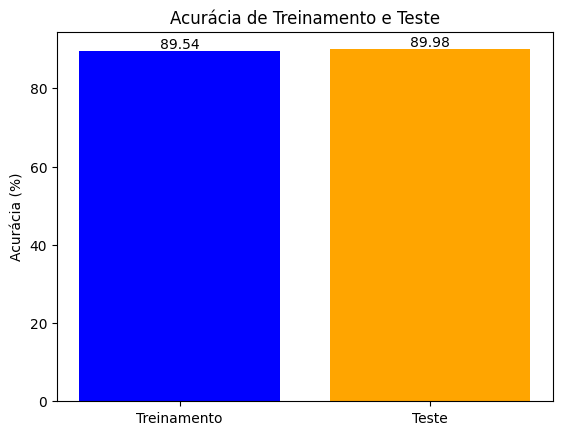

In [80]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


Foi possivel obseravar uma grande melhora em comparação ao anterior, tambem vale a pena observar que não é um problema nem de underfitting ou overfitting ja que os dados quando comparados treino e teste são quanse identicos.

Em seguida reamais uma redução na camada oculta, para reduzir a complexidade.

In [81]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 120  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 15
batch_size = 128 
learning_rate = 0.005

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 9.8800
Época [1/15], Acurácia de Teste: 74.0000
Época [2/15], Acurácia de Teste: 80.8400
Época [3/15], Acurácia de Teste: 84.3200
Época [4/15], Acurácia de Teste: 86.3300
Época [5/15], Acurácia de Teste: 87.5500
Época [6/15], Acurácia de Teste: 88.2100
Época [7/15], Acurácia de Teste: 88.7400
Época [8/15], Acurácia de Teste: 89.0700
Época [9/15], Acurácia de Teste: 89.3600
Época [10/15], Acurácia de Teste: 89.7200
Época [11/15], Acurácia de Teste: 89.9000
Época [12/15], Acurácia de Teste: 90.1400
Época [13/15], Acurácia de Teste: 90.3400
Época [14/15], Acurácia de Teste: 90.4700
Época [15/15], Acurácia de Teste: 90.6500


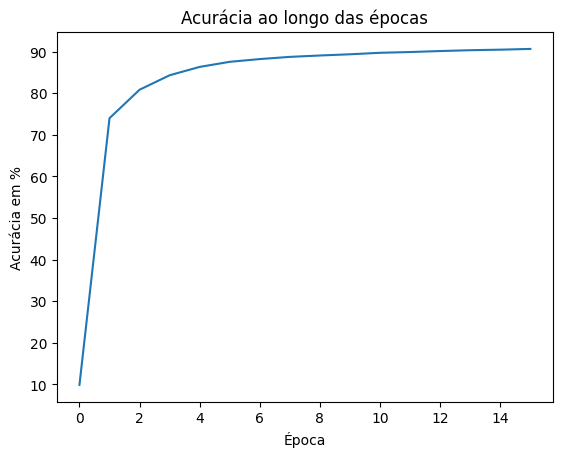

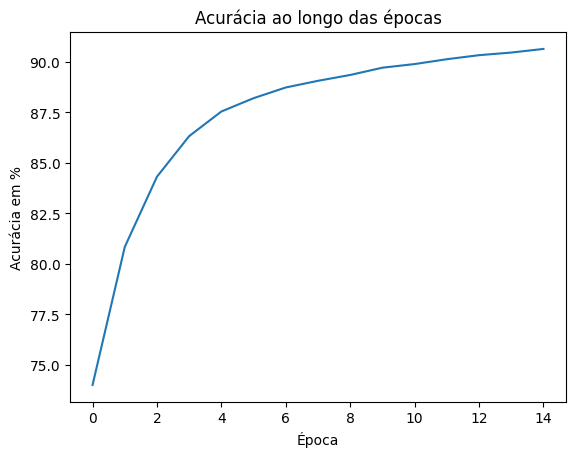

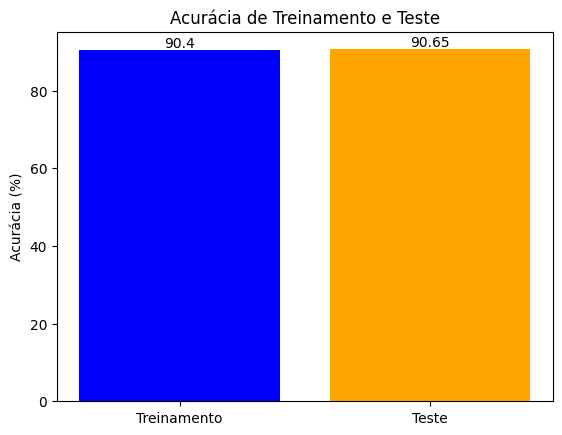

[9.879999999999999, 74.0, 80.84, 84.32, 86.33, 87.55, 88.21, 88.74, 89.07000000000001, 89.36, 89.72, 89.9, 90.14, 90.34, 90.47, 90.64999999999999]
[90.39666666666668, 90.64999999999999]


In [82]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento2)
print([valor_treino, valor_teste])


É perceptível que não houve muita diferença, logo irei realizar mais um teste, manter o LR já que parece estável além de aumentar o número de episódios já que o crescimento ainda se mostra bem evidente e contínuo epor fim almentar a camada interna ja que os resultados parecem levemente menores.

In [83]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 150  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 25
batch_size = 128 
learning_rate = 0.01

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 10.5000
Época [1/25], Acurácia de Teste: 81.1100
Época [2/25], Acurácia de Teste: 86.6700
Época [3/25], Acurácia de Teste: 88.4700
Época [4/25], Acurácia de Teste: 89.3500
Época [5/25], Acurácia de Teste: 89.9900
Época [6/25], Acurácia de Teste: 90.2600
Época [7/25], Acurácia de Teste: 90.6600
Época [8/25], Acurácia de Teste: 90.9400
Época [9/25], Acurácia de Teste: 91.1900
Época [10/25], Acurácia de Teste: 91.5100
Época [11/25], Acurácia de Teste: 91.7400
Época [12/25], Acurácia de Teste: 91.9100
Época [13/25], Acurácia de Teste: 92.0400
Época [14/25], Acurácia de Teste: 92.2800
Época [15/25], Acurácia de Teste: 92.3400
Época [16/25], Acurácia de Teste: 92.5100
Época [17/25], Acurácia de Teste: 92.7400
Época [18/25], Acurácia de Teste: 92.7800
Época [19/25], Acurácia de Teste: 92.9200
Época [20/25], Acurácia de Teste: 93.0300
Época [21/25], Acurácia de Teste: 93.1000
Época [22/25], Acurácia de Teste: 93.1600
Época [23/25], Acurácia de Teste: 93.3000
Época [24/25], Ac

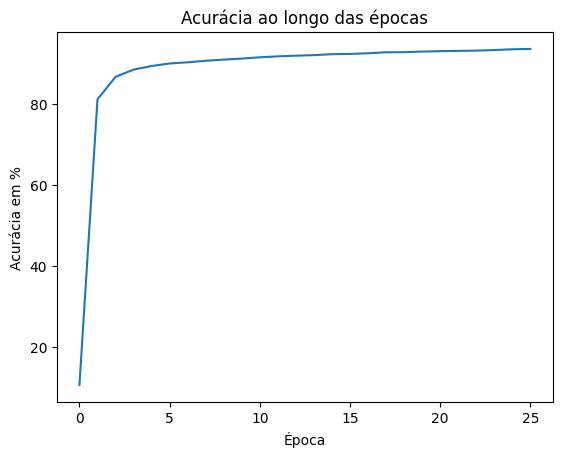

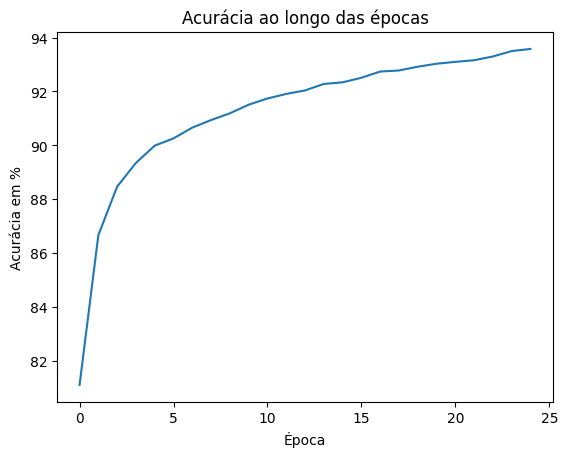

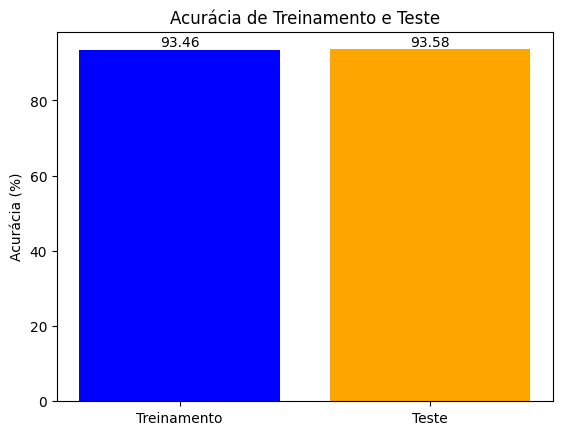

[10.5, 81.11, 86.67, 88.47, 89.35, 89.99000000000001, 90.25999999999999, 90.66, 90.94, 91.19, 91.51, 91.74, 91.91, 92.04, 92.28, 92.34, 92.51, 92.74, 92.78, 92.92, 93.03, 93.10000000000001, 93.16, 93.30000000000001, 93.5, 93.58]
[93.45833333333333, 93.58]


In [84]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento2)
print([valor_treino, valor_teste])


# Nota final

Fica notavel que apesar de o modelo melhorar a cada epsodio o mesmo esta melhorando de forma bem linear

[94.53666666666666, 94.35] # valores de acuracia de treino e teste respectivamente.

# Vale a pena salientar que como estamos lidando com a escrita humana não achei legal aplicar transformações as imagens
coisa que testei e se provou verdade demorando 18 epsodios para chegar a 90% de acuracia

abaixo mais um pq não aguentei, nesse caso como ainda havia espaço para melhora contínua no anterior, resolvi aumentar  mais uma vez o LR


In [85]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 150  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 25
batch_size = 128 
learning_rate = 0.06

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 7.2500
Época [1/25], Acurácia de Teste: 90.1100
Época [2/25], Acurácia de Teste: 91.8400
Época [3/25], Acurácia de Teste: 92.6300
Época [4/25], Acurácia de Teste: 93.5800
Época [5/25], Acurácia de Teste: 94.0800
Época [6/25], Acurácia de Teste: 94.6600
Época [7/25], Acurácia de Teste: 94.9400
Época [8/25], Acurácia de Teste: 95.2300
Época [9/25], Acurácia de Teste: 95.5300
Época [10/25], Acurácia de Teste: 95.7300
Época [11/25], Acurácia de Teste: 95.9500
Época [12/25], Acurácia de Teste: 96.1700
Época [13/25], Acurácia de Teste: 96.3200
Época [14/25], Acurácia de Teste: 96.4300
Época [15/25], Acurácia de Teste: 96.5800
Época [16/25], Acurácia de Teste: 96.7200
Época [17/25], Acurácia de Teste: 96.8700
Época [18/25], Acurácia de Teste: 96.9400
Época [19/25], Acurácia de Teste: 97.0800
Época [20/25], Acurácia de Teste: 97.0500
Época [21/25], Acurácia de Teste: 97.1900
Época [22/25], Acurácia de Teste: 97.2700
Época [23/25], Acurácia de Teste: 97.3800
Época [24/25], Acu

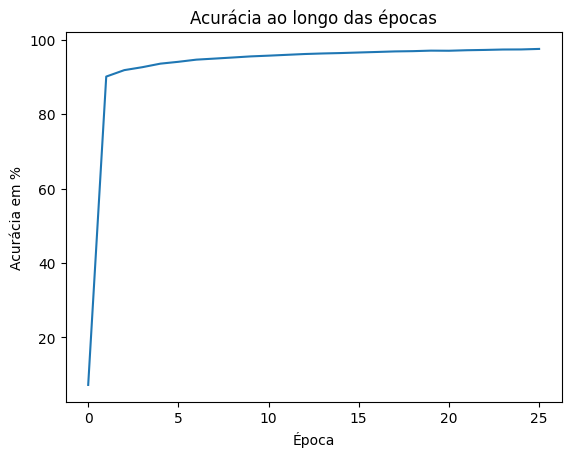

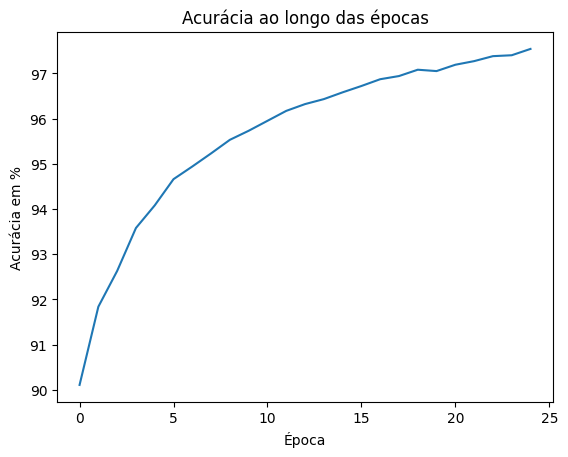

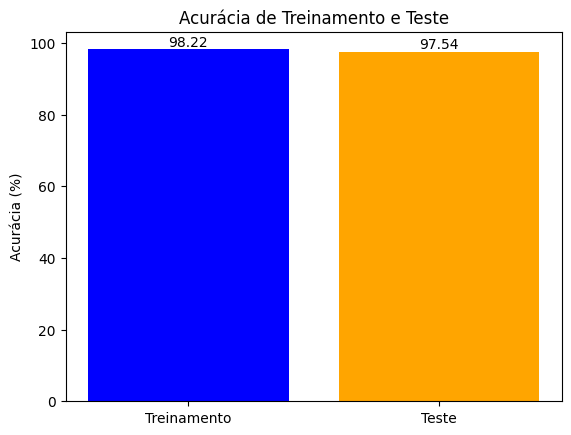

[7.249999999999999, 90.11, 91.84, 92.63, 93.58, 94.08, 94.66, 94.94, 95.23, 95.53, 95.73, 95.95, 96.17, 96.32, 96.43, 96.58, 96.72, 96.87, 96.94, 97.08, 97.05, 97.19, 97.27, 97.38, 97.39999999999999, 97.54]
[98.22, 97.54]


In [86]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento2)
print([valor_treino, valor_teste])
